In [1]:
import os
import shutil
import sys
import pickle
import numpy as np
import pandas as pd
import warnings
from PIL import Image, ImageFilter
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

warnings.simplefilter("ignore")
np.random.seed(100)

In [2]:
#calculates gradient both using Mean squared error and cross entropy
class SigmoidNeuron:
    
    '''
    This class provides capability to calculate prediction using sigmoid function. It allows you to calculate gradient 
    either using mean squared error or cross entropy. Fit function takes following input - epochs, learning_rate,
    intialisation - to iniatise w and b (default is true), loss function (default is MSE),
    display_loss - to display loss function (default is False) 
    '''
    
    def __init__(self):
        self.w = None
        self.b = None
    
    def perceptron(self, x):
        return np.dot(x, self.w.T) + self.b
  
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
  
    def grad_w_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)
  
    def grad_w_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        if y == 0:
            return y_pred * x
        elif y == 1:
            return -1 * (1 - y_pred) * x
        else:
            raise ValueError("y should be 0 or 1")
    
    def grad_b_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        if y == 0:
            return y_pred 
        elif y == 1:
            return -1 * (1 - y_pred)
        else:
            raise ValueError("y should be 0 or 1")
  
    def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", 
            display_loss=False,display_test_loss=False):
        
        X, X_test, Y, Y_test = train_test_split(X,Y,random_state=0, stratify=Y_train, test_size=0.1)
    
        # initialise w, b
        if initialise:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0
      
        if display_loss:
            loss = {}
            loss_test={}
    
        for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            dw = 0
            db = 0
            for x, y in zip(X, Y):
                if loss_fn == "mse":
                    dw += self.grad_w_mse(x, y)
                    db += self.grad_b_mse(x, y) 
                elif loss_fn == "ce":
                    dw += self.grad_w_ce(x, y)
                    db += self.grad_b_ce(x, y)
            self.w -= learning_rate * dw
            self.b -= learning_rate * db
            
            # display the training error
            Y_pred = self.sigmoid(self.perceptron(X))
            Y_pred_test = self.sigmoid(self.perceptron(X_test))
            if display_loss:
                if loss_fn == "mse":
                    loss[i] = mean_squared_error(Y, Y_pred)
                    loss_test[i] = mean_squared_error(Y_test,Y_pred_test)
                elif loss_fn == "ce":
                    loss[i] = log_loss(Y, Y_pred)
                    loss_test[i] = log_loss(Y_test,Y_pred_test)
              
            
        if display_loss:
            plt.plot(loss.values(),label='Train Set')
            if display_test_loss:
                plt.plot(loss_test.values(),label='Test Set')
            plt.xlabel('Epochs')
            plt.legend()
            if loss_fn == "mse":
                plt.ylabel('Mean Squared Error')
            elif loss_fn == "ce":
                plt.ylabel('Log Loss')
            plt.show()
        
        return loss,loss_test
    
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        return np.array(Y_pred)

##### Reading data

In [3]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    global images_plot
    images_plot = []
    files = os.listdir(folder_path)
    white_on_black = lambda x: 0 if x > 8 else 255
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        #image = image.filter(ImageFilter.DETAIL())
        image = image.point(lambda x:x*1.3)
        image = image.filter(ImageFilter.GaussianBlur(0.15))
        
        image = image.convert('L').point(white_on_black)
        image = image.filter(ImageFilter.MedianFilter(3))
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [4]:
languages = ['ta', 'hi', 'en']

images_train = read_all("C:/Users/mgangwar/Desktop/DeepLearning/Comp/level_4a_train/level_4a/background", key_prefix='bgr_') # change the path
for language in languages:
    images_train.update(read_all("C:/Users/mgangwar/Desktop/DeepLearning/Comp/level_4a_train/level_4a/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("C:/Users/mgangwar/Desktop/DeepLearning/Comp/level_4a_test", key_prefix='') # change the path
print(len(images_test))

Reading:



Reading:



Reading:



Reading:



9000
Reading:



3000


In [5]:
list(images_test.keys())[:5]

['0', '1', '10', '100', '1000']

In [6]:
X_train = []
Y_train = []

#if the image has bgr_ then it has no text 
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
    ID_test.append(int(key))
    X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(9000, 4096) (9000,)
(3000, 4096)


##### Standardisation

In [7]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

print(X_scaled_train.shape, Y_train.shape)
print(X_scaled_test.shape)

(9000, 4096) (9000,)
(3000, 4096)


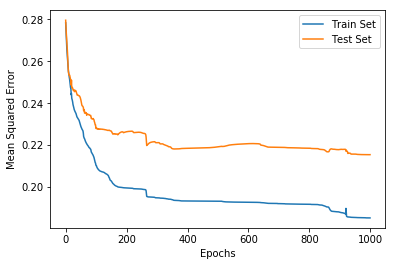

0.0015    0.18532115122129783 0.2154640875248822


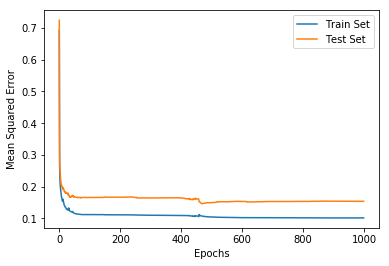

0.015    0.10086466245227484 0.15329855668463696


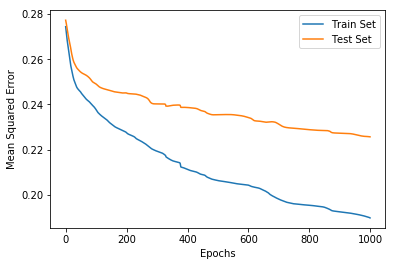

0.00015    0.189702117636019 0.22562323279490265


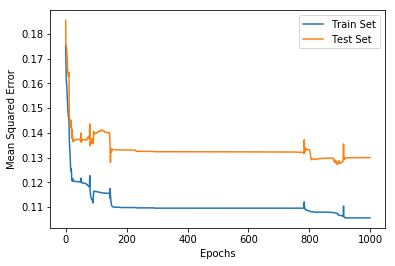

0.045    0.10555563161167902 0.12996727426641522


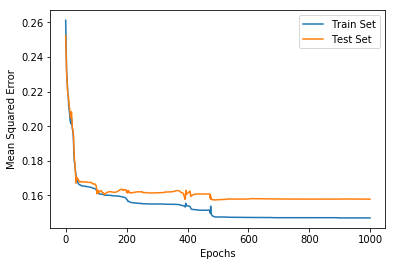

0.0045    0.1470393610038295 0.15790091777658327


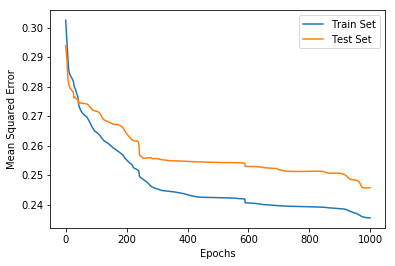

0.00045    0.23548211273391914 0.2457191537434683


In [8]:
eta = [0.0015,0.015,0.00015,0.045,0.0045,0.00045]

for i in eta:
    sn_mse = SigmoidNeuron()
    loss_train, loss_test = sn_mse.fit(X_scaled_train, Y_train, epochs=1000, learning_rate=i, loss_fn="mse", display_loss=True,
                                      display_test_loss=True)
    print(i , "  " ,list(loss_train.values())[-1],list(loss_test.values())[-1])

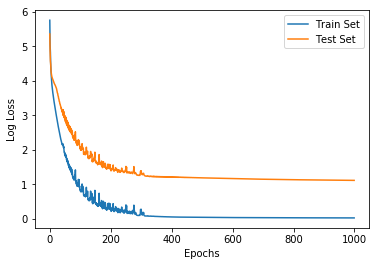

0.00015    0.029065157997682903 1.1178195205134105


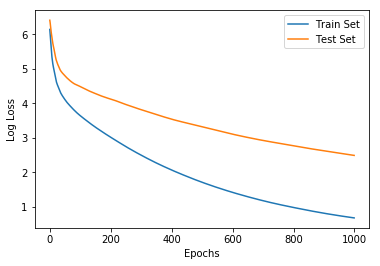

1.5e-05    0.6789840843456864 2.492120798782058


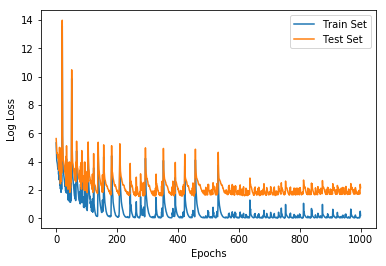

0.0015    0.19926656290266204 2.1655015716726953


In [12]:
eta = [0.00015,0.000015,0.0015]

for i in eta:
    sn_ce = SigmoidNeuron()
    loss_train, loss_test = sn_ce.fit(X_scaled_train, Y_train, epochs=1000, learning_rate=i, loss_fn="ce", 
                                      display_loss=True,display_test_loss=True)
    print(i , "  " ,list(loss_train.values())[-1],list(loss_test.values())[-1])

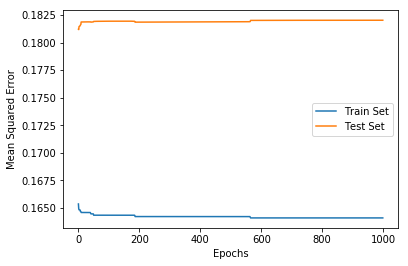

0.0015    0.1640740761946938 0.1820306934533144


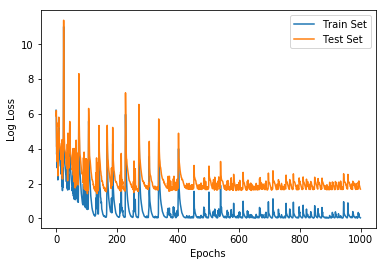

0.0015    0.027868344575706635 1.6809262912930254


In [16]:
sn_mse = SigmoidNeuron()
loss_train, loss_test = sn_mse.fit(X_scaled_train, Y_train, epochs=1000, learning_rate=0.045, loss_fn="mse", display_loss=True,display_test_loss=True)
print(i , "  " ,list(loss_train.values())[-1],list(loss_test.values())[-1])

sn_ce = SigmoidNeuron()
loss_train, loss_test = sn_ce.fit(X_scaled_train, Y_train, epochs=1000, learning_rate=0.0015, loss_fn="ce", display_loss=True,display_test_loss=True)
print(i , "  " ,list(loss_train.values())[-1],list(loss_test.values())[-1])

In [17]:
def print_accuracy(sn):
    Y_pred_train = sn.predict(X_scaled_train)
    Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
    accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
    print("Train Accuracy : ", accuracy_train)
    print("-"*50)

In [18]:
print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.8341111111111111
--------------------------------------------------
Train Accuracy :  0.9876666666666667
--------------------------------------------------


## Sample Submission

In [19]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)